In [1]:
import numpy as np
import torch
import cv2
from ultralytics.engine.results import Masks

In [2]:
import matplotlib.pyplot as plt

In [51]:
from ultralytics import YOLO

img_path = "img/people.jpg"

# Build a YOLOv9c model from pretrained weight
model = YOLO("yolov9c-seg.pt")

# Display model information (optional)
model.info()

# Run inference with the YOLOv9c model on the 'bus.jpg' image
results = model(img_path)

YOLOv9c-seg summary: 654 layers, 27,897,120 parameters, 0 gradients

image 1/1 /media/local/the last one/images/img/people.jpg: 448x640 6 persons, 2 handbags, 1 tie, 2 cell phones, 8585.6ms
Speed: 131.6ms preprocess, 8585.6ms inference, 69.5ms postprocess per image at shape (1, 3, 448, 640)


In [52]:
len(results[0]), len(results[0].masks), len(results[0].masks.data)

(11, 11, 11)

In [54]:
def generate_hsv_colors(num_classes):
    """ Generate evenly spaced colors in the HSV space and convert them to RGB. """
    colors = []
    for i in range(num_classes):
        hue = int(180 * i / num_classes)  # Vary the hue between 0 and 180 (OpenCV hue range)
        color = np.uint8([[[hue, 255, 255]]])  # Full saturation and value
        rgb_color = cv2.cvtColor(color, cv2.COLOR_HSV2BGR)[0][0]
        colors.append(rgb_color)

    return colors

# Generate HSV-based colors for 80 classes
class_colors = generate_hsv_colors(len(results[0].names))

In [113]:
image = cv2.imread(img_path)

# Get the dimensions of the image
height, width, _ = image.shape

# Set the figure size based on the image dimensions
plt.figure(figsize=(width / 100, height / 100))

<Figure size 1024x683 with 0 Axes>

<Figure size 1024x683 with 0 Axes>

In [232]:
def overlay_masks_on_image(image, results, class_colors, alpha=0.5, labels=True):
    """
    Overlay masks for multiple instances per class on the original image.

    Args:
        image: Original image (as a NumPy array).
        masks: Dictionary where each key is a class ID, and the value is a list of binary masks (one for each instance).
        class_colors: Dictionary mapping class IDs to RGB colors.
        alpha: Transparency of the overlay (0 = transparent, 1 = opaque).
    """

    for c, obj in zip(results[0].boxes.cls.type(torch.int).numpy(), results[0].masks.xy):

        # Convert the polygon coordinates to integer
        polygon = np.array(obj, dtype=np.int32)

        # Get the color for the current class
        color = class_colors[c]

        # Create a mask for the polygon
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 1)

        # Create a color mask (with the same shape as the image)
        color_mask = np.zeros_like(image)
        color_mask[mask == 1] = color

        # Overlay the mask on the image using the transparency factor
        image = cv2.addWeighted(image, 1, color_mask, 0.5, 0)

        # Draw the polygon outline on the image
        image = cv2.polylines(image, [polygon], isClosed=True, color=color.tolist(), thickness=3, lineType=cv2.LINE_AA)

        if True:
            # Find the centroid of the mask to place the label
            moments = cv2.moments(mask)
            if moments["m00"] != 0:
                cX = int(moments["m10"] / moments["m00"])
                cY = int(moments["m01"] / moments["m00"])
                class_name = results[0].names[c]
                        
                # Get the text size
                text_size = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.65, 2)[0]
                        
                # Create a white background for the text with larger padding
                text_bg = np.full((text_size[1] + 8, text_size[0] + 8, 3), 255, dtype=np.uint8)
                        
                # Ensure the overlay dimensions match the target region in the image
                y1, y2 = cY - text_size[1]//2 - 4, cY + text_size[1]//2 + 4
                x1, x2 = cX - text_size[0]//2 - 4, cX + text_size[0]//2 + 4
                y1, y2 = max(0, y1), min(image.shape[0], y2)
                x1, x2 = max(0, x1), min(image.shape[1], x2)
                text_bg = text_bg[:y2-y1, :x2-x1]
                        
                # Overlay the text background on the image
                image[y1:y2, x1:x2] = text_bg
                        
                # Put the text on the image
                cv2.putText(image, class_name, (cX - text_size[0]//2, cY + text_size[1]//2), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 0), 2)

    return image

In [233]:
image = cv2.imread(img_path)

# Overlay masks on the image
output_image = overlay_masks_on_image(image, results, class_colors)

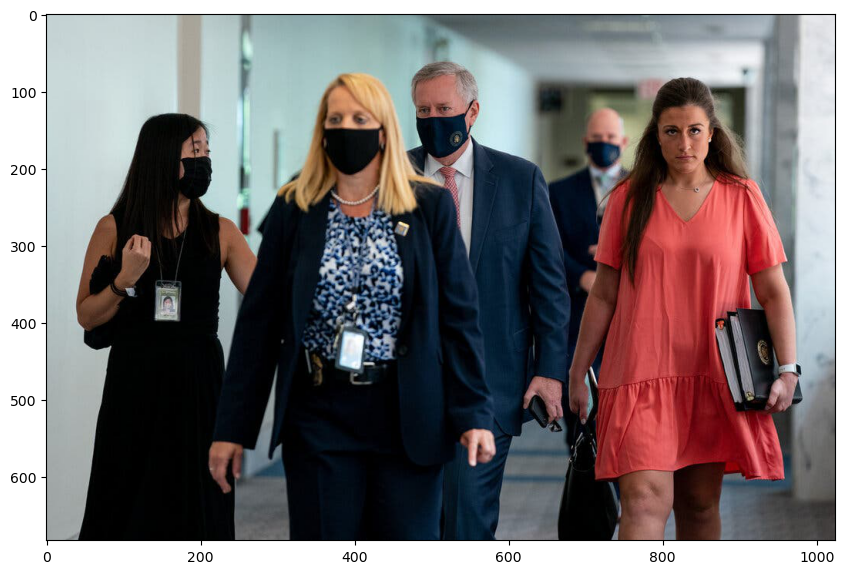

In [228]:
plt.figure(figsize=(width / 100, height / 100))
plt.imshow(image[...,::-1])

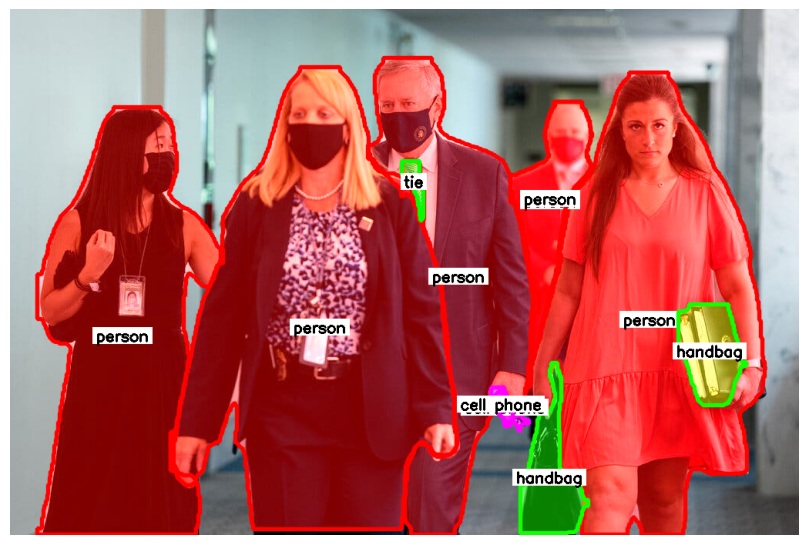

In [234]:
plt.figure(figsize=(width / 100, height / 100))
# Display the image
plt.imshow(output_image[..., ::-1])
plt.axis('off')  # Hide the axis
plt.show()